In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import os
import io
from PIL import Image
from collections import deque

In [2]:
class PrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6, NUM_ROWS=0, NUM_COLS=0):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        if capacity == -1:
            self.priorities = np.zeros((0,), dtype=np.float32)
        else:
            self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.epsilon    = 1e-3        # small constant to add to TD-error, make sure p_i > 0
        self.state_nums = np.array([]).astype(int)
        self.NUM_ROWS   = NUM_ROWS
        self.NUM_COLS   = NUM_COLS
    
    # state: tuple
    # action: integer
    # next_state: tuple
    def push(self, state, action, reward, next_state, done):
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if self.capacity != -1:
            if len(self.buffer) < self.capacity:
                self.buffer.append((state, action, reward, next_state, done))
                self.state_nums = np.append(self.state_nums, state[0] * self.NUM_COLS + state[1])
            else:
                self.buffer[self.pos] = (state, action, reward, next_state, done)
                self.state_nums[self.pos] = state[0] * self.NUM_COLS + state[1]

            # when first inserted, it has max priority 
            self.priorities[self.pos] = max_prio
            self.pos = (self.pos + 1) % self.capacity
        else:
            self.buffer.append((state, action, reward, next_state, done))
            self.state_nums = np.append(self.state_nums, state[0] * self.NUM_COLS + state[1])
            
            # when first inserted, it has max priority 
            self.priorities = np.append(self.priorities, max_prio)
            self.pos = self.pos + 1
    
    def sample(self, batch_size, beta=0.4, M=None):
        if self.capacity == -1:
            prios = self.priorities
            state_nums = self.state_nums
        else:
            if len(self.buffer) == self.capacity:
                prios = self.priorities
                state_nums = self.state_nums
            else:
                prios = self.priorities[:self.pos]
                state_nums = self.state_nums[:self.pos]

        need_values = 1
        # generate probabilities of all transitions using alpha
        # if M is not none, take into account the need matrix
        if M is not None:
            if M.min() < 0:
                M_pos = M - M.min() + self.epsilon
            else:
                M_pos = M
            need_values = M_pos[state_nums]
        
        if self.prob_alpha is not None:
            # TODO: idea from PSER:
            # - if need_value < 1, prios * 1
            # - if need_value > 1, prios * need_value
            
            probs  = (prios * need_values) ** self.prob_alpha
#             probs  = (prios ** self.prob_alpha) * need_values
            probs /= probs.sum()
        
            # sample using the probs
            indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        else:
            indices = np.array([np.argmax(prios)])
        samples = [self.buffer[idx] for idx in indices]
    
        # importance sampling weights
        # for now it is naive: all is 1
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
#         weights = np.ones(indices.shape)
        
        batch       = list(zip(*samples))
        states      = np.array(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.array(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    # update the priority of experiences at indices in batch_incices
    # p_i = |delta_i| + epsilon
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio + self.epsilon

    def __len__(self):
        return len(self.buffer)

In [3]:
class CliffWalk:
    def __init__(self, custom_map):
        # parse from the custom_map
        self.map = custom_map
        self.states = []
        self.obstacles = []
        self.start = None
        self.goal = None
        self.NUM_ROWS = len(custom_map)
        self.NUM_COLS = len(custom_map[0])
        
        for i in range(self.NUM_ROWS):
            for j in range(self.NUM_COLS):
                cell = custom_map[i][j]
                if cell == 'S':
                    self.start = (i, j)
                elif cell == 'G':
                    self.goal = (i, j)
                elif cell == 'O':
                    self.obstacles.append((i, j))
                self.states.append((i, j))   
        # initial state
        self.reset()

        # all possible actions
        self.ACTION_RIGHT = 0
        self.ACTION_DOWN = 1
        self.actions = [self.ACTION_RIGHT, self.ACTION_DOWN]
        
    # check whether a state can be reached
    def is_reachable(self, state):
        return state in self.states and state not in self.obstacles

    # reset the maze state
    def reset(self):
        self.curr_state = self.start

    # compute next state given current state and action
    def next_state(self, state, action):
        x, y = state
        next_state = None
        if action == 0:
            next_state = (x, y + 1)
        elif action == 1:
            next_state = (x + 1, y)
            
        next_state = next_state if self.is_reachable(next_state) else state
        return next_state

    # take a step
    def step(self, action):
        x, y = self.curr_state
        next_state = None
        if action == 0:
            next_state = (x, y + 1)
        elif action == 1:
            next_state = (self.start[0], self.start[1])

        done = next_state == self.goal
        
        # if reward is good, update the random reward value
        if done:
            reward = 1
        else:
            reward = 0
        
        # reward = 1.0 if done else 0.0
        
        self.curr_state = next_state
        return next_state, reward, done

In [32]:
class VanillaDQN:
    def __init__(self, maze):
        self.k = 1         # sample minibatch size
        self.ita = 0.25     # learning rate for the Q function approximator
        self.K = 1         # for how many timesteps do we need a replay
        self.alpha = 0.6     # for sampling transitions
        self.beta = 0.4    # for importance sampling annealing
        self.epsilon = 0.05 # epsilon greedy policy
        
        self.maze = maze
        self.buffer = PrioritizedBuffer(capacity=-1, prob_alpha=self.alpha, NUM_ROWS=self.maze.NUM_ROWS, NUM_COLS=self.maze.NUM_COLS)
        
        self.gamma = 1 - 1 / (self.maze.NUM_COLS)   # the discount factor
        
        self.Q = np.zeros((len(self.maze.states) * len(self.maze.actions), 1))  # the Q function. 
        
        # need term (lambda)
        self.lambda_M = 0.5     # TD(lambda) parameter
        self.eligibility = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
        self.gamma_M = 0.95   # the discount rate for the need matrix
        self.alpha_M = 0.5    # step update size (learning rate) for successor representation
        
        self.steps_per_episode = []
        
        self.T = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, self.maze.NUM_ROWS * self.maze.NUM_COLS))
        
        # create the random M
        start_state_num = self.state_to_number(self.maze.start)
        for state in self.maze.states:
            state_num = self.state_to_number(state)
            if state != self.maze.goal:
                for action in self.maze.actions:
                    next_state = self.maze.next_state(state, action)
                    next_state_num = self.state_to_number(next_state)
                    self.T[state_num, next_state_num] = 0.5
                    self.T[state_num, start_state_num] = 0.5
            # for goal, just trivial case
            else:
                self.T[state_num, state_num] = 0
                
        self.M = np.linalg.solve(np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS) - self.T * self.gamma, np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS))
        self.M_random = np.linalg.solve(np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS) - self.T * self.gamma, np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS))
        
        # create the optimal M
        self.T_optimal = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, self.maze.NUM_ROWS * self.maze.NUM_COLS))
        start_state_num = self.state_to_number(self.maze.start)
        for state in self.maze.states:
            state_num = self.state_to_number(state)
            if state != self.maze.goal:
                for action in self.maze.actions:
                    next_state = self.maze.next_state(state, action)
                    next_state_num = self.state_to_number(next_state)
                    self.T_optimal[state_num, next_state_num] = 1
                    self.T_optimal[state_num, start_state_num] = 0
            # for goal, just trivial case
            else:
                self.T_optimal[state_num, state_num] = 0
        self.M_optimal = np.linalg.solve(np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS) - self.T_optimal * self.gamma, np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS))
        
        self.current_Q_update = None # the current state-action pair of Q update (used in GIF generation)
        self.current_num_Q_update = 0 # the current number of Q updates made
        self.gif_steps = -1       # make a frame per some updates 
        self.gif_frames = []   # the place to store all images for the gif
        self.max_frames = -1   # the max_number of frames in the gif to be specified
        
        self.Q_map = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))   # proxy to display q value map
        self.prob_map = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS, len(self.maze.actions))) # to display the probability distributions

        
    # convert a state to number
    def state_to_number(self, state):
        return self.maze.NUM_COLS * state[0] + state[1]
    
    # state-action pair to number
    def pair_to_number(self, state, action):
        return self.state_to_number(state) * len(self.maze.actions) + action
        
    # convert a state-action pair to a one-hot notation
    def pair_to_onehot(self, state, action):
        one_hot = np.zeros((len(self.maze.states) * len(self.maze.actions), 1))
        idx = self.pair_to_number(state, action)
        one_hot[idx] = 1
        return one_hot
    
    # select action by epsilon greedy
    def epsilon_greedy(self, state):
        x = np.random.rand()
        pair_nums = [self.pair_to_number(state, action) for action in self.maze.actions]
        action_values = self.Q[pair_nums][:, 0]
        
        if x > self.epsilon:
            return np.random.choice(np.flatnonzero(np.isclose(action_values, action_values.max())))
        else:
            return np.random.choice(self.maze.actions)
        
    # compute TD error
    def compute_td(self, state, action, reward, next_state):
        max_next_q = np.max(self.Q[[self.pair_to_number(next_state, action) for action in self.maze.actions]])
        error = reward + self.gamma * max_next_q - self.Q[self.pair_to_number(state, action)]
        return error
    
    def step(self, action):
        next_state, reward, done = self.maze.step(action)
        if done:
            self.maze.reset()
        return reward, next_state, done
    
    # run the agent
    # M: can use the M already learned
    def run_episode(self, n_episode=50, need=None, gif_steps=-1, max_frames=-1, M_learned=None):
        self.gif_steps = gif_steps
        self.max_frames = max_frames
        self.maze.reset()
        # self.steps_per_episode = []
        delta = np.zeros((len(self.maze.states) * len(self.maze.actions), 1))
        
        # record time
        curr_timestep = 0
        curr_episode = 0
        curr_episode_steps = 0
        
        # chose initial action
        state = deepcopy(self.maze.curr_state)
        action = self.epsilon_greedy(state)
        total_Q_updates = 0
        
        while curr_episode < n_episode:
            curr_episode_steps += 1
            curr_timestep += 1
            reward, next_state, done = self.step(action)
            
            # update M
            if need == 'lambda':
                # one-hot vector for current state
                one_hot_state = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
                one_hot_state[self.state_to_number(state), 0] = 1
                # one-hot vector for next state
                one_hot_next_state = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
                one_hot_next_state[self.state_to_number(next_state), 0] = 1
                
                
                self.eligibility = self.gamma_M * self.lambda_M * self.eligibility + one_hot_state
                self.M += self.alpha_M * self.eligibility.dot(one_hot_state.T + self.gamma_M * one_hot_next_state.T.dot(self.M) - one_hot_state.T.dot(self.M))
            
            if done:
                curr_episode += 1
                self.steps_per_episode.append(curr_episode_steps)
                curr_episode_steps = 0
            
            self.buffer.push(state, action, reward, next_state, done)
            
            # every K steps, do sweeping
            if curr_timestep % self.K == 0:
                # do k sweeps in total
                for i in range(self.k):
                    current_state_num = self.state_to_number(self.maze.curr_state)
                    if need == 'lambda':
                        states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=M_learned[current_state_num, :] if M_learned is not None else self.M[current_state_num, :])
                    elif need == None:
                        states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=None)
                    _state = states[0]
                    _action = actions[0]
                    curr_sampled_pair = (tuple(_state), _action)
                    _reward = rewards[0]
                    _next_state = next_states[0]
                    weight = weights[0]
                    
                    TD_error = self.compute_td(_state, _action, _reward, _next_state)
                    self.buffer.update_priorities(indices, [abs(TD_error)])
                    # also update the prob_map for display. 
                    # epsilon is the small constant to keep all priorities > 0
                    delta += weight * TD_error * self.pair_to_onehot(_state, _action)
                
                # update Q function parameters and reset delta
                self.Q += self.ita * delta
                total_Q_updates += 1
                delta = np.zeros((len(self.maze.states) * len(self.maze.actions), 1))
                    
            # choose action
            state = deepcopy(self.maze.curr_state)
            action = self.epsilon_greedy(state)
        
        return curr_episode, total_Q_updates
            
    def run_converge(self, threshold=0.01, need=None, M_learned=None, mag=False):
        self.maze.reset()
        # self.steps_per_episode = []
        delta = np.zeros((len(self.maze.states) * len(self.maze.actions), 1))
        
        # record time
        curr_timestep = 0
        curr_episode = 0
        curr_episode_steps = 0
        total_Q_updates = 0
        
        # chose initial action
        state = deepcopy(self.maze.curr_state)
        action = self.epsilon_greedy(state)
        
        # get optimal Q values
        optimal_Q = self.calculate_optimal()
        
        while True:
            curr_episode_steps += 1
            curr_timestep += 1
            reward, next_state, done = self.step(action)
            
            # update M
            if need == 'lambda':
                # one-hot vector for current state
                one_hot_state = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
                one_hot_state[self.state_to_number(state), 0] = 1
                # one-hot vector for next state
                one_hot_next_state = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
                one_hot_next_state[self.state_to_number(next_state), 0] = 1
                
                
                self.eligibility = self.gamma_M * self.lambda_M * self.eligibility + one_hot_state
                self.M += self.alpha_M * self.eligibility.dot(one_hot_state.T + self.gamma_M * one_hot_next_state.T.dot(self.M) - one_hot_state.T.dot(self.M))
            elif need == 'greedy':
                for state in self.maze.states:
                    state_num = self.state_to_number(state)
                    if state != self.maze.goal:
                        self.T[state_num, :] = np.zeros((1, len(self.maze.states)))
                        best_action = self.epsilon_greedy(state)
                        next_state = self.maze.next_state(state, best_action)
                        next_state_num = self.state_to_number(next_state)
                        self.T[state_num, next_state_num] = 1 - self.epsilon + self.epsilon / len(self.maze.states)
                        
                        for action in self.maze.actions:
                            self.T[state_num, self.state_to_number(self.maze.next_state(state, action))] = self.epsilon / len(self.maze.states)
                self.M = np.linalg.solve(np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS) - self.T * self.gamma, np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS)) 
                            
            
            if done:
                curr_episode += 1
                self.steps_per_episode.append(curr_episode_steps)
                curr_episode_steps = 0
                
                # if converge, just break
                num_states = len(self.maze.map[0]) - 1
#                 print(np.sum(np.abs(self.Q[[x * 2 for x in range(num_states)]].reshape((num_states,)) - optimal_Q)))
                if np.sum((self.Q[[x * 2 for x in range(num_states)]].reshape((num_states,)) - optimal_Q) ** 2) < threshold:
                    break
            
#             self.buffer.push(state, action, reward, next_state, done)
            
            # every K steps, do sweeping
            if curr_timestep % self.K == 0:
                # do k sweeps in total
                for i in range(self.k):
                    current_state_num = self.state_to_number(self.maze.curr_state)
                    
                    if mag: 
                        if need == 'oracle':
                            best_state = self.maze.start
                            max_update = 0
                            for state in self.maze.states:
                                if state != self.maze.goal:
                                    x, y = state
                                    reward = 0
                                    done = False
                                    if (x, y + 1) == self.maze.goal:
                                        reward = 1
                                    update_value = reward + self.gamma * self.Q[self.pair_to_number((x, y + 1), 0), 0] - self.Q[self.pair_to_number(state, 0), 0]
                                    if update_value > max_update:
                                        max_update = update_value
                                        best_state = state
                                        done = (best_state[0], best_state[1] + 1) == self.maze.goal

                            states = [best_state] 
                            actions = [0]
                            rewards = [0]
                            next_states = [(best_state[0], best_state[1] + 1)]
                            dones = [done]
                            weights = [1]
                        else:
                            states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=None)
                    else:
                        if need == 'lambda':
                            states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=M_learned[current_state_num, :] if M_learned is not None else self.M[current_state_num, :])
                        elif need == 'greedy':
                            states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=self.M[current_state_num, :])
                        elif need == 'optimal':
                            states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=self.M_optimal[current_state_num, :])
                        elif need == 'random':
                            states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=self.M_random[current_state_num, :])
                        elif need == None:
                            states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(1, self.beta, M=None)
                        elif need == 'oracle':
                            best_state = self.maze.start
                            max_update = 0
                            for state in self.maze.states:
                                if state != self.maze.goal:
                                    x, y = state
                                    reward = 0
                                    done = False
                                    if (x, y + 1) == self.maze.goal:
                                        reward = 1
                                    update_value = reward + self.gamma * self.Q[self.pair_to_number((x, y + 1), 0), 0] - self.Q[self.pair_to_number(state, 0), 0]
                                    if update_value > max_update:
                                        max_update = update_value
                                        best_state = state
                                        done = (best_state[0], best_state[1] + 1) == self.maze.goal

                            states = [best_state] 
                            actions = [0]
                            rewards = [0]
                            next_states = [(best_state[0], best_state[1] + 1)]
                            dones = [done]
                            weights = [1]          
                                
                    _state = states[0]
                    _action = actions[0]
                    curr_sampled_pair = (tuple(_state), _action)
                    _reward = rewards[0]
                    if need == 'oracle':
                        if (_state[0], _state[1] + 1) == self.maze.goal:
                            _reward = 1
                    _next_state = next_states[0]
                    weight = weights[0]
                    
                    TD_error = self.compute_td(_state, _action, _reward, _next_state)
                    if need != 'oracle':
                        self.buffer.update_priorities(indices, [abs(TD_error)])
                    # also update the prob_map for display. 
                    # epsilon is the small constant to keep all priorities > 0
                    
                    # try the magnitude plan
                    if mag:
                        if need == 'lambda':
                            n = M_learned[current_state_num, self.state_to_number(_state)] if M_learned is not None else self.M[current_state_num, self.state_to_number(_state)]
                        elif need == 'greedy':
                            n = self.M[current_state_num, self.state_to_number(_state)]
                        elif need == 'optimal':
                            n = self.M_optimal[current_state_num, self.state_to_number(_state)]
                        elif need == 'random':
                            n = self.M_random[current_state_num, self.state_to_number(_state)]
                        else:
                            n = 1
                        delta += weight * n * TD_error * self.pair_to_onehot(_state, _action)
                    else:
                        delta += weight * TD_error * self.pair_to_onehot(_state, _action)
                
                # update Q function parameters and reset delta
                self.Q += self.ita * delta
                total_Q_updates += 1
                delta = np.zeros((len(self.maze.states) * len(self.maze.actions), 1))
                    
            # choose action
            state = deepcopy(self.maze.curr_state)
            action = self.epsilon_greedy(state)
            
        return curr_episode, total_Q_updates
            
    def print_policy(self):
        directions = ["→", "↓"]
        for i in range(self.maze.NUM_ROWS):
            row = []
            for j in range(self.maze.NUM_COLS):
                if (i, j) == self.maze.start:
                    row.append("S")
                elif (i, j) == self.maze.goal:
                    row.append("G")
                else:
                    pair_nums = [self.pair_to_number((i, j), action) for action in self.maze.actions]
                    action_values = self.Q[pair_nums][:, 0]
                    row.append(directions[np.argmax(action_values)])
            print("".join(row))
            
    def push_samples(self):
        samples = []
        simulator = CliffWalk(self.maze.map)
        n = len(self.maze.map[0]) - 1
        for i in range(0, 2 ** n):
            simulator.reset()
            bin_string = bin(i)[2:]
            
            if len(bin_string) < n:
                bin_string = '0' * (n - len(bin_string)) + bin_string
            for j in range(0, n):
                state = deepcopy(simulator.curr_state)
                action = int(bin_string[j])
                next_state, reward, done = simulator.step(action)
                samples.append((state, action, reward, next_state, done))
        np.random.shuffle(samples)
        
        for transition in samples:
            state, action, reward, next_state, done = transition
            self.buffer.push(state, action, reward, next_state, done)
            
    def calculate_optimal(self):
        num_states = len(self.maze.map[0]) - 1
        
        optimal = []
        for i in range(num_states):
            optimal.append(self.gamma ** (num_states - i - 1))
        return np.array(optimal)

In [19]:
custom_map = [
    'SFFFFFFFFG',
]
agent = VanillaDQN(CliffWalk(custom_map))
agent.push_samples()

In [26]:
agent.run_converge(threshold=0.001, need='oracle', M_learned=None)

(1, 8)

In [27]:
# NOTE: HERE I HAVE TURNED OFF PUSH SAMPLE
updates_uniform = []
for i in range(5):
    agent = VanillaDQN(CliffWalk(custom_map))
    agent.buffer.pro_alpha = 0.0
    agent.push_samples()
    eps, ups = agent.run_converge(threshold=0.001, need=None, M_learned=None)
    updates_uniform.append(ups)
np.mean(updates_uniform)

13007.8

In [28]:
# PER
updates = []
for i in range(5):
    agent = VanillaDQN(CliffWalk(custom_map))
    agent.push_samples()
    eps, ups = agent.run_converge(threshold=0.001, need=None, M_learned=None)
    updates.append(ups)
np.mean(updates)

13146.4

In [42]:
# NEED
updates_need_test = []
for i in range(15):
    agent = VanillaDQN(CliffWalk(custom_map))
    agent.lambda_M = 0.95
    agent.push_samples()
    eps, ups = agent.run_converge(threshold=0.001, need='lambda', M_learned=None, mag=False)
    updates_need_test.append(ups)
np.mean(updates_need_test)

7014.866666666667

In [44]:
updates_PER = []
updates_need = []
updates_need_optimal = []
updates_need_random = []
num_samples = []
updates_oracle = []
updates_uniform = []

In [45]:
n_start = 1
n_end = 11
ten_state_need = None
lambda_M_agent = None

In [46]:
times = 15
for i in range(n_start, n_end):
    num_samples.append(i * 2 ** i)

# for different sizes
for i in range(n_start, n_end):
    
    temp_PER = []
    temp_need = []
    temp_need_optimal = []
    temp_need_random = []
    temp_oracle = []
    temp_uniform = []
    
    for time in range(times):
        custom_map = [
            'S' + 'F' * i + 'G',
        ]
        
        agent = VanillaDQN(CliffWalk(custom_map))
        agent.push_samples()
        eps, ups = agent.run_converge(threshold=0.001, need=None, M_learned=None)
        temp_PER.append(ups)
        
        agent = VanillaDQN(CliffWalk(custom_map))
        agent.lambda_M = 0.95
        agent.push_samples()
        eps, ups = agent.run_converge(threshold=0.001, need='lambda', M_learned=None)
        temp_need.append(ups)
        if i == 10:
            ten_state_need = agent.M
            lambda_M_agent = agent
        
        agent = VanillaDQN(CliffWalk(custom_map))
        agent.push_samples()
        eps, ups = agent.run_converge(threshold=0.001, need='optimal', M_learned=None)
        temp_need_optimal.append(ups)
        
        agent = VanillaDQN(CliffWalk(custom_map))
        agent.push_samples()
        eps, ups = agent.run_converge(threshold=0.001, need='random', M_learned=None)
        temp_need_random.append(ups)
        
        agent = VanillaDQN(CliffWalk(custom_map))
        agent.push_samples()
        eps, ups = agent.run_converge(threshold=0.001, need='oracle', M_learned=None)
        temp_oracle.append(ups)
        
        agent = VanillaDQN(CliffWalk(custom_map))
        agent.buffer.prob_alpha = 0.0
        agent.push_samples()
        eps, ups = agent.run_converge(threshold=0.001, need=None, M_learned=None)
        temp_uniform.append(ups)
        
    updates_PER.append(np.mean(temp_PER))
    updates_need.append(np.mean(temp_need))
    updates_need_optimal.append(np.mean(temp_need_optimal))
    updates_need_random.append(np.mean(temp_need_random))
    updates_oracle.append(np.mean(temp_oracle))
    updates_uniform.append(np.mean(temp_uniform))

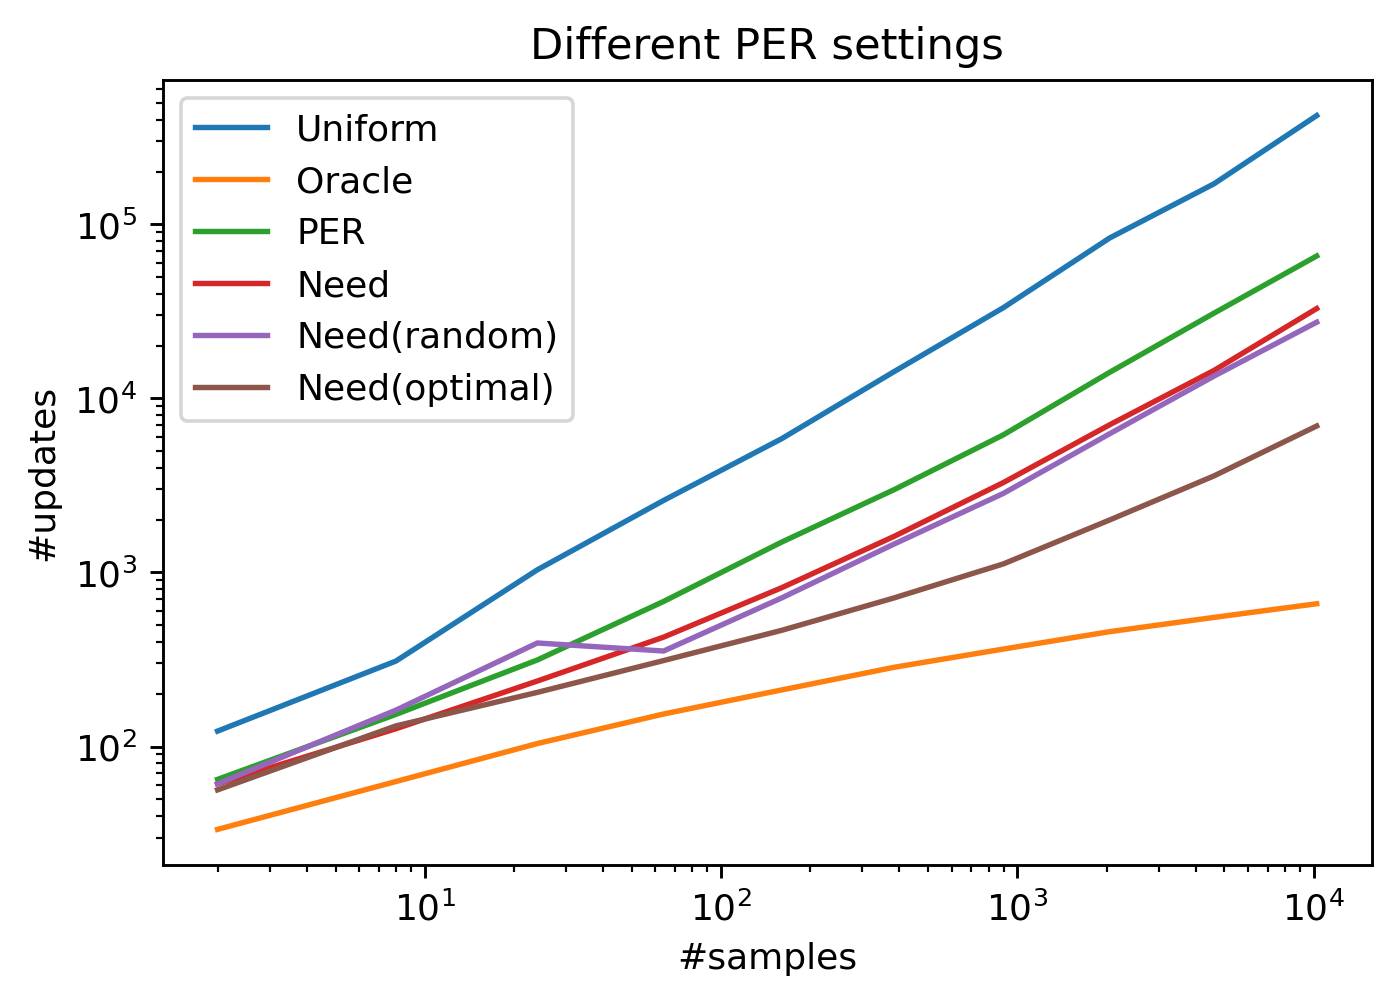

In [47]:
axes = plt.gca()
# axes.set_xlim([1, 50])
# axes.set_ylim([10, 1000])
plt.xlabel("#samples")
plt.ylabel("#updates")
plt.xscale("log")
plt.yscale("log")

plt.plot(num_samples, updates_uniform, label='Uniform')
plt.plot(num_samples, updates_oracle, label='Oracle')
plt.plot(num_samples, updates_PER, label='PER')
plt.plot(num_samples, updates_need, label='Need')
plt.plot(num_samples, updates_need_random, label='Need(random)')
plt.plot(num_samples, updates_need_optimal, label='Need(optimal)')
axes.set_title("Different PER settings")
plt.legend()

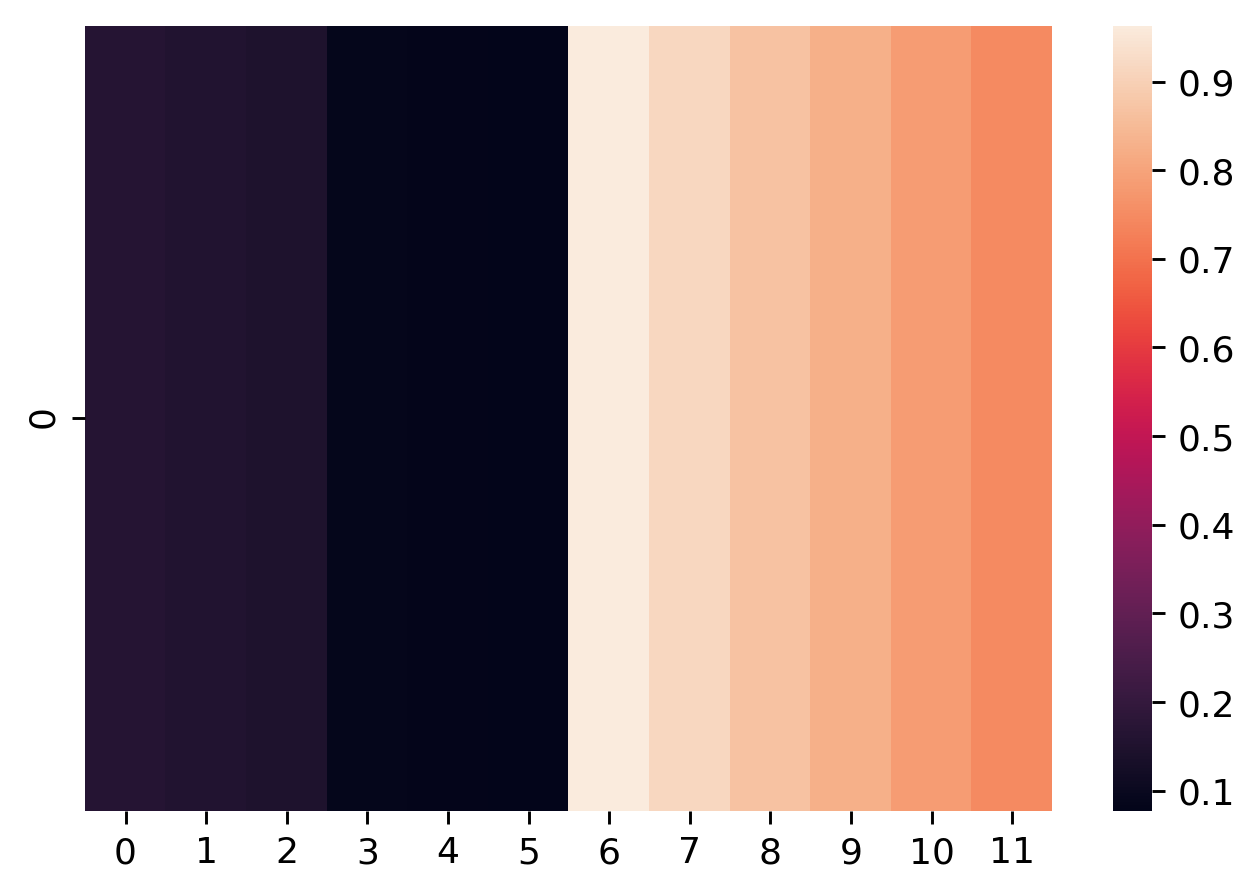

In [48]:
sns.heatmap(ten_state_need[6].reshape((1, 12)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


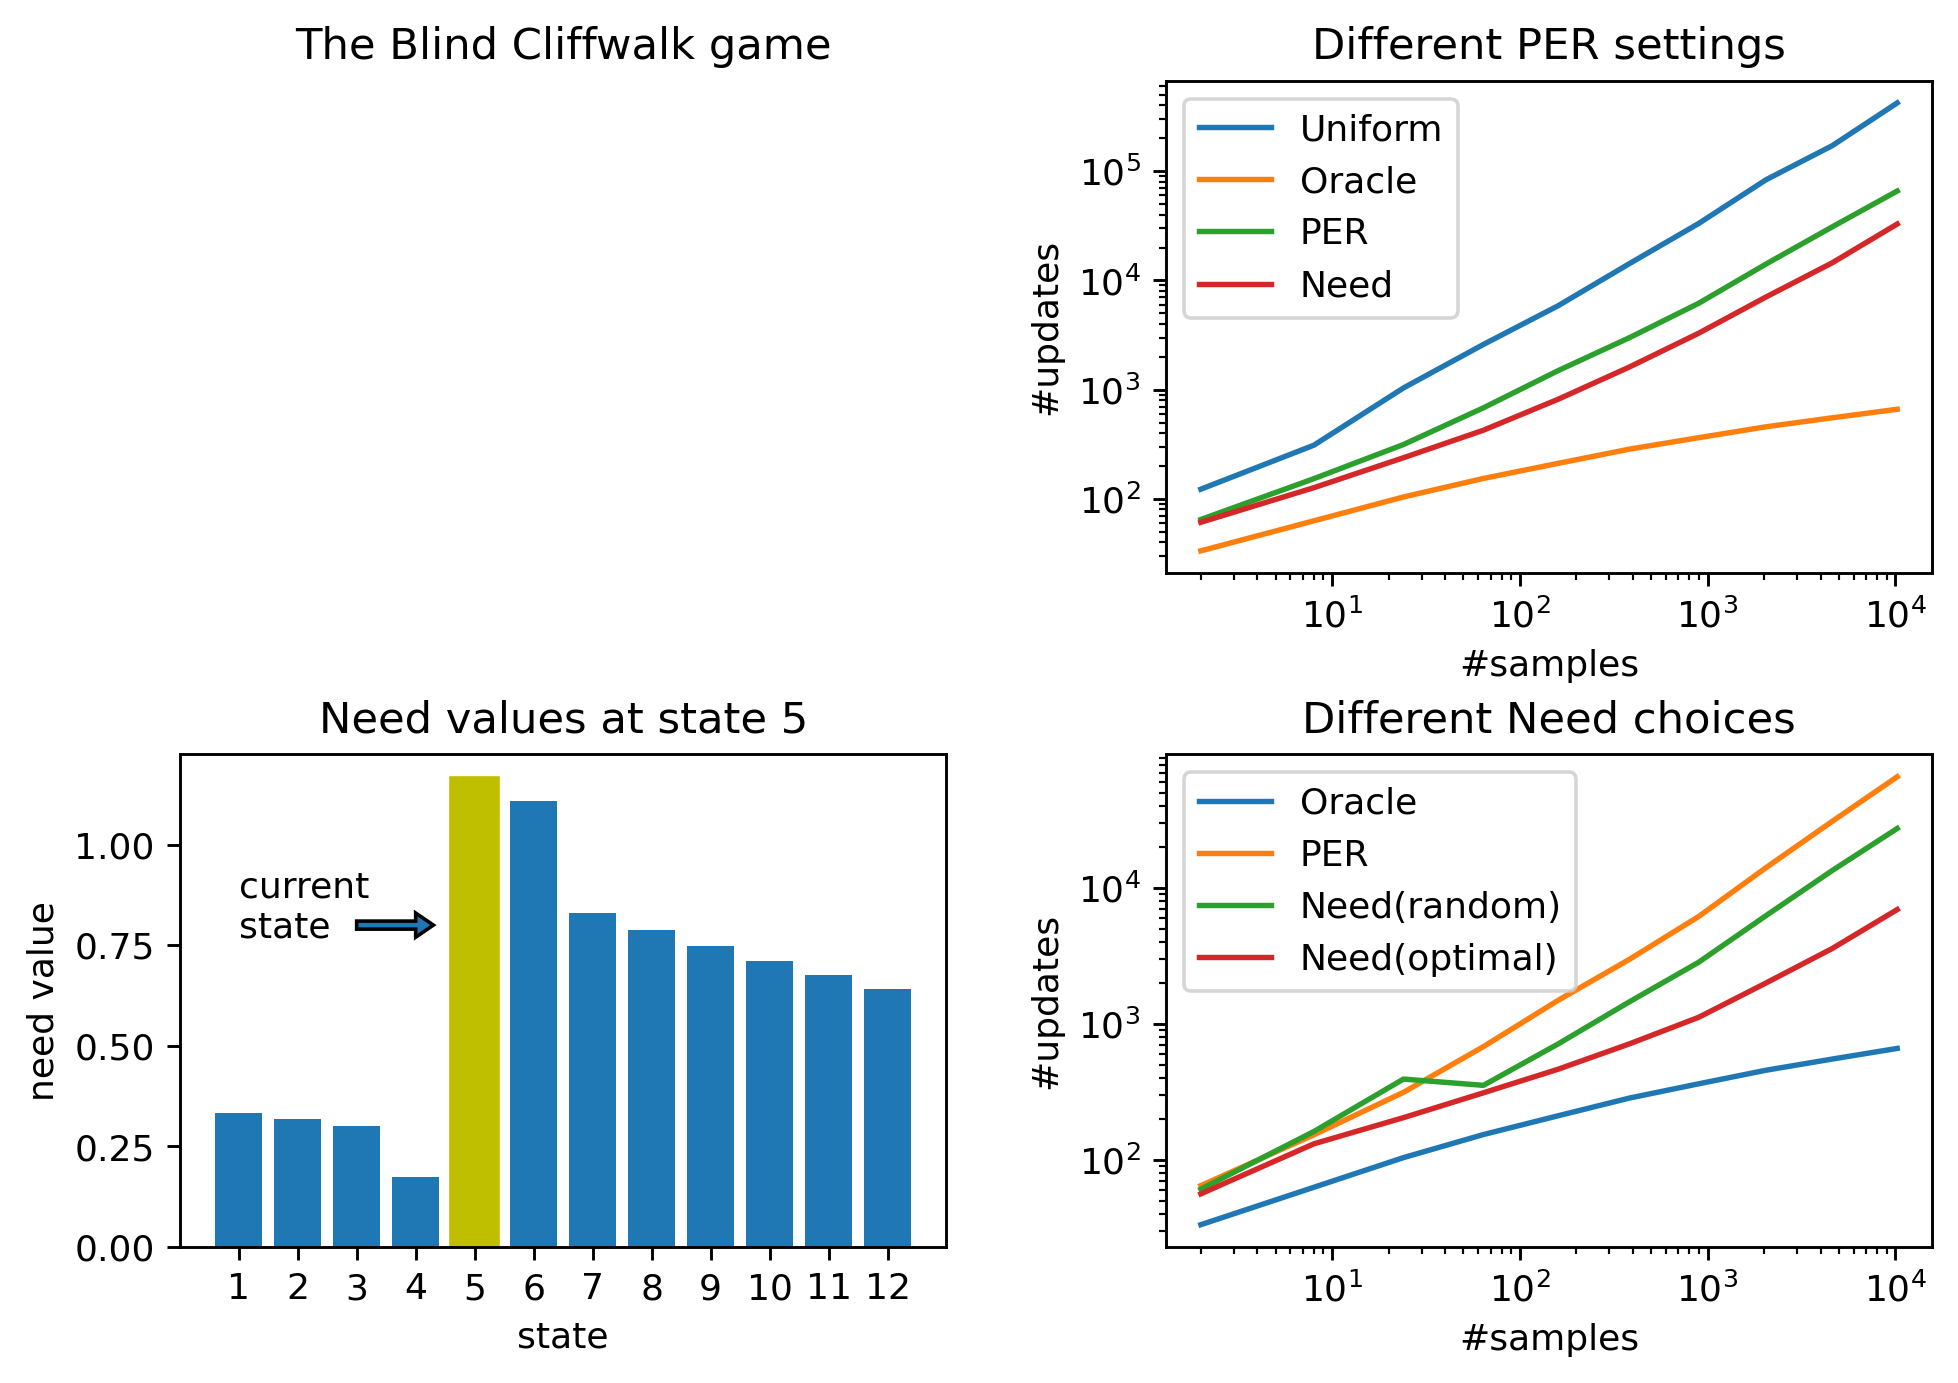

In [62]:
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 260


num_cols = 2
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 5.6))
fig.tight_layout(pad=3.0) 

# the cliffwalk example
# img1 = mpimg.imread('cliff.svg')
# axs[0, 0].imshow(img1)
axs[0, 0].axis('off')
axs[0, 0].set_title("The Blind Cliffwalk game")

# the log lines 
axs[0, 1].set_xlabel("#samples")
axs[0, 1].set_ylabel("#updates")
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")


axs[0, 1].plot(num_samples, updates_uniform, label='Uniform')
axs[0, 1].plot(num_samples, updates_oracle, label='Oracle')
axs[0, 1].plot(num_samples, updates_PER, label='PER')
axs[0, 1].plot(num_samples, updates_need, label='Need')
axs[0, 1].set_title("Different PER settings")
axs[0, 1].legend()

# the state bar plot
barlist = axs[1, 0].bar(list(range(1, 13, 1)), list(ten_state_need[4]))
barlist[4].set_color('y')
axs[1, 0].set_xlabel("state")
axs[1, 0].set_ylabel("need value")
axs[1, 0].set_xticks(list(range(1, 13, 1)))
axs[1, 0].arrow(3, 0.8, 1, 0, width = 0.02, head_length=0.3)
axs[1, 0].text(1, 0.77, "current\nstate")
axs[1, 0].set_title("Need values at state 5")

# need interval
axs[1, 1].set_xlabel("#samples")
axs[1, 1].set_ylabel("#updates")
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")

# plt.plot(num_samples, updates_uniform, label='Uniform')
axs[1, 1].plot(num_samples, updates_oracle, label='Oracle')
axs[1, 1].plot(num_samples, updates_PER, label='PER')
axs[1, 1].plot(num_samples, updates_need_random, label='Need(random)')
axs[1, 1].plot(num_samples, updates_need_optimal, label='Need(optimal)')
axs[1, 1].set_title("Different Need choices")
axs[1, 1].legend()

plt.savefig('cliff_four.eps', format='eps')

[-0.009373263854550035,
 -0.008904600661810147,
 -0.003353116194167643,
 -0.0032838115891700584,
 -0.0031196210088476747,
 -0.0029784076595538445,
 0.9970543769048957,
 0.947155999662594,
 0.8997981996955672,
 0.8593502121406409,
 0.8163827015336089,
 0.7755635665515395]

In [17]:
axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D060EA0490>,
      dtype=object)

In [59]:
axs[1, 0].bar(list(range(10)), list(range(10)))

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

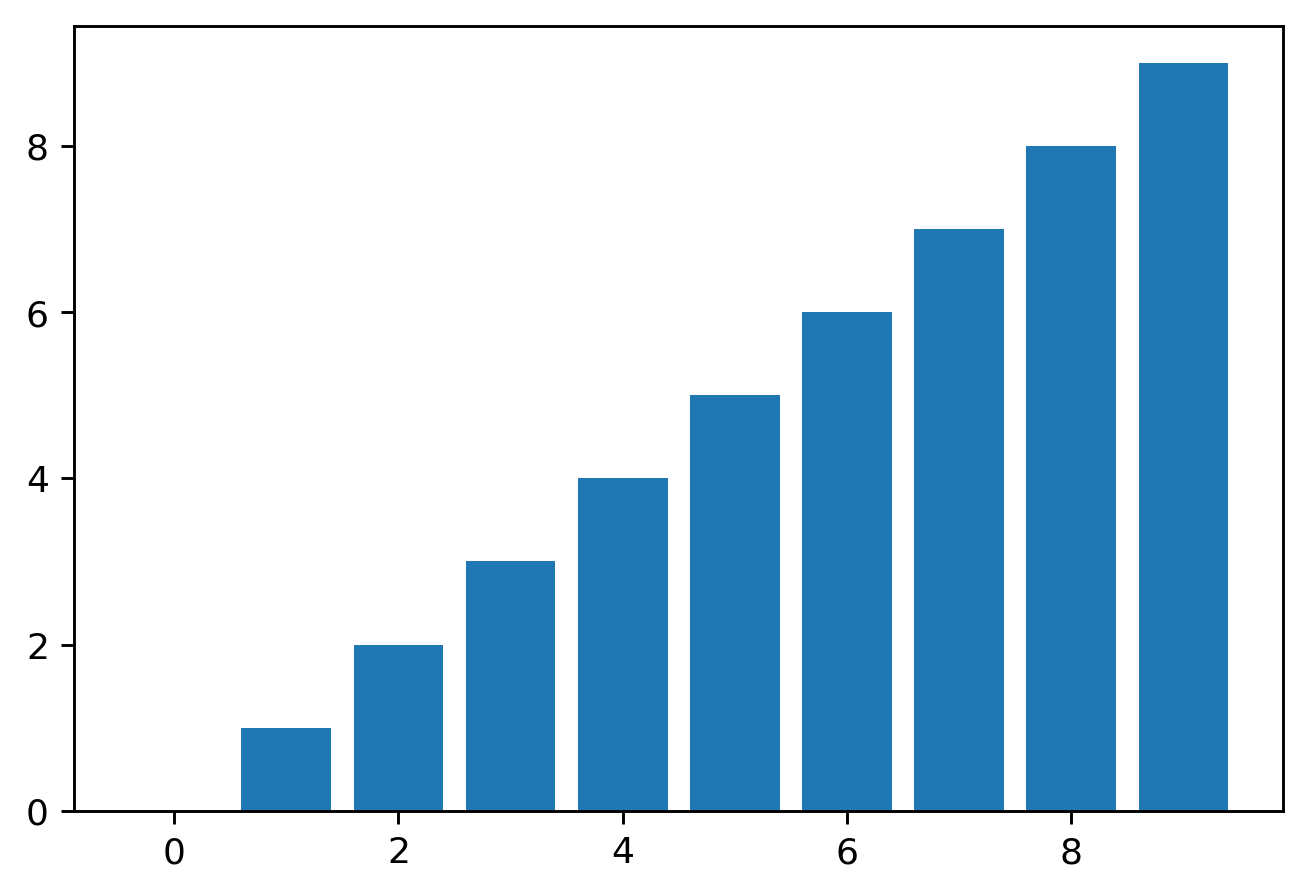

In [60]:
plt.bar(list(range(10)), list(range(10)))